# Fine-tuning CNN for Diabetes Classification

## Pre-training Phase

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
data = pd.read_csv('data/diabetes.csv')
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

(429, 8) (108, 8) (231, 8)


In [5]:
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [6]:
train_dataset = DiabetesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DiabetesDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DiabetesDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class DiabetesConv1D(nn.Module):
    def __init__(self, num_classes=2):
        super(DiabetesConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(np.unique(y))
net = DiabetesConv1D(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.7366, Validation Accuracy: 0.7222
Epoch [20/100], Train Accuracy: 0.7622, Validation Accuracy: 0.7593
Epoch [30/100], Train Accuracy: 0.7995, Validation Accuracy: 0.7685
Epoch [40/100], Train Accuracy: 0.8065, Validation Accuracy: 0.7685
Epoch [50/100], Train Accuracy: 0.8205, Validation Accuracy: 0.8056
Epoch [60/100], Train Accuracy: 0.8322, Validation Accuracy: 0.7963
Epoch [70/100], Train Accuracy: 0.8415, Validation Accuracy: 0.7870
Epoch [80/100], Train Accuracy: 0.8578, Validation Accuracy: 0.8148
Epoch [90/100], Train Accuracy: 0.8322, Validation Accuracy: 0.8148
Epoch [100/100], Train Accuracy: 0.8741, Validation Accuracy: 0.8148


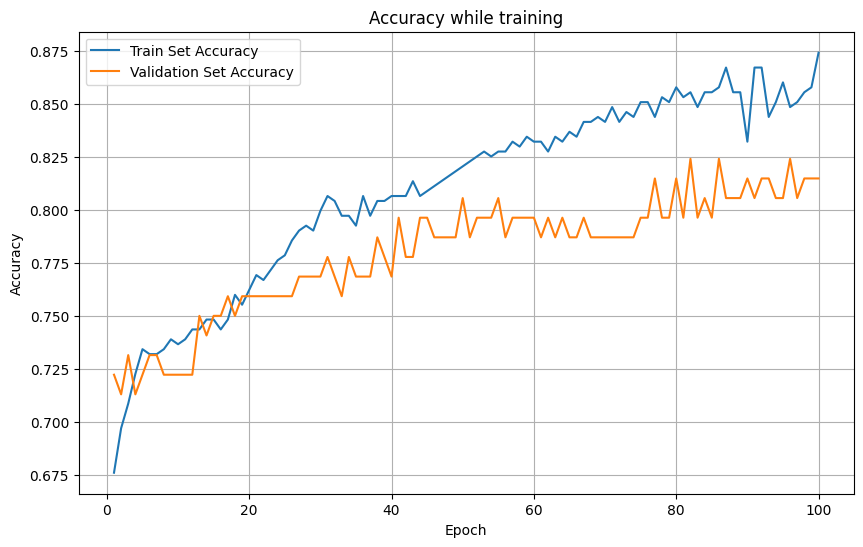

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [11]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.7273
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       151
           1       0.60      0.64      0.62        80

    accuracy                           0.73       231
   macro avg       0.70      0.71      0.70       231
weighted avg       0.73      0.73      0.73       231



In [12]:
model_save_path = 'trained_nets/trained_model.pth'
torch.save(net.state_dict(), model_save_path)

## Fine-tuning Phase: More Linear Layers

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
data = pd.read_csv('data/diabetes.csv')
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

(429, 8) (108, 8) (231, 8)


In [20]:
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [21]:
train_dataset = DiabetesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DiabetesDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DiabetesDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
class HeavierDiabetesConv1D(nn.Module):
    def __init__(self, num_classes=2):
        super(HeavierDiabetesConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.new_fc1 = nn.Linear(32, 16)
        self.new_fc2 = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.new_fc1(x))
        x = self.dropout(x)
        x = self.new_fc2(x)
        return x

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_save_path = 'trained_nets/trained_model.pth'

num_classes = len(np.unique(y))
net = HeavierDiabetesConv1D(num_classes)
net.load_state_dict(torch.load(model_save_path), strict=False)
net.to(device)

for name, param in net.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

/var/folders/7d/n6nvf8n51ws86n2p2yx5ks_80000gn/T/ipykernel_19581/3939973135.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_save_pat

In [24]:
num_epochs = 50
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/50], Train Accuracy: 0.7855, Validation Accuracy: 0.7500
Epoch [20/50], Train Accuracy: 0.8159, Validation Accuracy: 0.7685
Epoch [30/50], Train Accuracy: 0.8298, Validation Accuracy: 0.7870
Epoch [40/50], Train Accuracy: 0.8601, Validation Accuracy: 0.8148
Epoch [50/50], Train Accuracy: 0.8531, Validation Accuracy: 0.8148


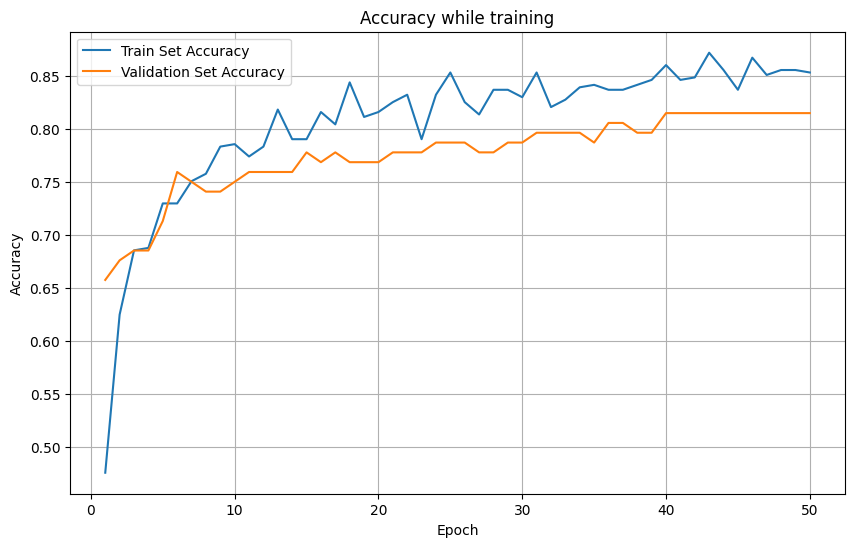

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [26]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.7229
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       151
           1       0.60      0.62      0.61        80

    accuracy                           0.72       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.73      0.72      0.72       231



## Fine-tuning Phase: To BMI Regression

In [27]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [28]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [29]:
data = pd.read_csv('data/diabetes.csv')
X = data.drop(['Outcome', 'BMI'], axis=1).values
y = data['BMI'].values

In [30]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test)

(429, 7) (108, 7) (231, 7)


In [31]:
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [32]:
train_dataset = DiabetesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DiabetesDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DiabetesDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class BMIConv1D(nn.Module):
    def __init__(self):
        super(BMIConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.regressor = nn.Linear(32, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x